In [1]:
# imports
import numpy as np

# Question 1: Implementation of Easy21

Below I create an environment implementing the game.
- reset(): generates the start state
- _draw_card() -> card: returns a card represented as a dictionary with "value" and "colour" keys
- step(action): -> (state, reward, terminated): takes an action (either "stick" or "hit") and returns a new state, a rewards (either -1, 0, or +1), and a Boolean denoting whether the terminal state has been reached


In [15]:
class Environment():
    def __init__(self):
        self.state = {
            "dealer_showing" : np.random.choice(np.arange(1, 11)),
            "player_sum": np.random.choice(np.arange(1, 11))
        }
        
    def reset(self):
        self.state = {
            "dealer_showing" : np.random.choice(np.arange(1, 11)),
            "player_sum": np.random.choice(np.arange(1, 11))
        }

        return self.state.copy()
        
    
    def _draw_card(self):
        value = np.random.choice(np.arange(1, 11))
        colour = np.random.choice(["red", "black"], p=[1/3, 2/3])
        card = {
            "value": value,
            "colour": colour,
        }
        return card
    
    
    def step(self, action):
        if action == "hit":
            card = self._draw_card()
            # Update the state based on the drawn card
            if card["colour"] == "black":
                self.state["player_sum"] = self.state["player_sum"] + card["value"]
            else:
                self.state["player_sum"] = self.state["player_sum"] - card["value"]

            # Terminate and return -1 if player went bust
            if self.state["player_sum"] > 21 or self.state["player_sum"] < 1:
                reward = -1
                terminated = True
            # Otherwise return a reward of 0
            else:
                terminated = False
                reward = 0
        
        if action == "stick":
            # We can already terminate as the dealer will keep drawing until a conclusion is reached
            terminated = True
            dealer_sum = self.state["dealer_showing"]
    
            while dealer_sum < 17:
                dealer_card = self._draw_card()
                if dealer_card["colour"] == "black":
                    dealer_sum = dealer_sum + dealer_card["value"]
                else:
                    dealer_sum = dealer_sum - dealer_card["value"]

            # Player wins either by dealer going bust or by having a greater sum
            if (dealer_sum > 21 or dealer_sum < 1) or self.state["player_sum"] > dealer_sum:
                reward = 1
            # Player draws
            elif dealer_sum == self.state["player_sum"]:
                reward = 0
            # Player loses
            else:
                reward = -1
    
        return self.state.copy(), reward, terminated

    def get_state(self):
        return self.state

# Question 2: Monte-Carlo Control

In [28]:
def uniform_random_policy():
    return "hit" if np.random.uniform() > 0.5 else "stick"

state_values = np.zeros((21, 10))
counts = np.zeros_like(values)

env = Environment()

# Monte Carlo Evaluation
for _ in range(1000):
    episode = {
        "states":[env.reset()],
        "rewards":[0],
        "actions":[],
    }
    
    terminated = False
    
    while not terminated:
        action = uniform_random_policy()
        state, reward, terminated = env.step(action)
        if not terminated:
            episode["states"].append(state.copy())
        episode["rewards"].append(reward)
        episode["actions"].append(action)

    for t, s in enumerate(episode["states"]):
        counts[s["player_sum"]-1, s["dealer_showing"]-1] += 1
        g = sum(episode["rewards"][t:])
        state_values[s["player_sum"]-1, s["dealer_showing"]-1] += (1/counts[s["player_sum"]-1, s["dealer_showing"]-1]) \
                                                          * (g-state_values[s["player_sum"]-1, s["dealer_showing"]-1])

In [29]:
counts

array([[13., 17., 10., 10., 14., 13., 16., 10., 14.,  9.],
       [15., 14., 12., 12., 12., 11., 16., 12.,  8., 10.],
       [16., 15., 11., 12.,  9., 14., 13., 12., 11., 15.],
       [17., 11.,  8., 12., 14., 19., 13.,  9.,  9.,  8.],
       [13., 16., 15.,  9., 16., 13., 20., 15., 14., 10.],
       [19., 18., 11.,  6., 21., 10., 12., 13.,  9., 15.],
       [21., 17., 11.,  8., 16., 27., 18., 13.,  7., 10.],
       [12., 15., 14., 16., 18., 17., 14., 13., 10., 13.],
       [18., 20., 13., 12., 17., 14., 11., 11., 11., 13.],
       [14., 17.,  9.,  8.,  8., 18., 22., 11., 15., 10.],
       [ 9.,  5.,  3.,  1.,  4.,  5.,  6.,  4.,  3.,  3.],
       [ 5.,  0.,  4.,  5.,  4.,  6.,  6., 12.,  5.,  7.],
       [ 3., 11.,  4.,  5.,  3.,  7.,  4.,  2.,  2.,  4.],
       [ 2.,  5.,  2.,  0.,  6.,  3.,  5.,  4.,  4.,  3.],
       [ 2.,  7.,  3.,  0.,  8.,  3.,  4.,  5.,  6.,  7.],
       [ 4.,  4.,  2.,  6.,  5.,  3.,  1.,  2.,  3.,  4.],
       [ 6.,  0.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,  4.

In [30]:
state_values.round(1)

array([[-0.7, -0.6, -1. , -0.4, -0.7, -0.4, -0.9, -0.6, -0.4, -0.8],
       [-0.9, -0.9, -0.8, -0.2, -0.7, -1. , -0.8,  0. , -0.5, -0.6],
       [-0.8, -0.6, -0.6, -0.5, -0.6, -0.6, -0.4, -0.3, -0.1, -0.6],
       [-0.8, -0.5, -0.8, -0.8, -0.7, -0.7, -0.2, -0.3, -0.8, -0.5],
       [-0.4, -0.4, -0.7, -0.8, -0.5, -0.8, -0.7, -0.9, -0.3, -1. ],
       [-0.9, -0.7, -0.8, -0.3, -0.4, -0.4, -0.7, -0.4, -0.6, -0.5],
       [-0.8, -0.4, -0.3, -0.2, -0.4, -0.5, -0.7, -0.7, -0.1, -0.6],
       [-0.3, -0.7, -0.6, -0.6, -0.4, -0.5, -0. , -0.4, -0. , -0.5],
       [-0.6, -0.7, -0.2, -0.8, -0.3, -0.9, -0.6, -0.5, -0.5, -1. ],
       [-0.7, -0.5, -0.3, -0.8,  0.2, -0.4, -0.5, -0.9, -0.7, -1. ],
       [-0.6,  0.2,  0.3, -1. , -1. ,  0.2, -0.3,  0.5, -0.3, -0.3],
       [-0.6,  0. , -0.5, -0.2,  0.5, -0.3, -0.3, -0.7, -0.6, -0.7],
       [-1. , -0.6, -1. , -0.6, -1. , -0.7,  0.5,  0. ,  0. , -0.5],
       [-1. ,  0.2, -1. ,  0. , -0.3,  0.3, -0.6,  0. , -0.5,  0.3],
       [-1. , -0.4, -1. ,  0. , -0

In [7]:
import matplotlib.pyplot as plt

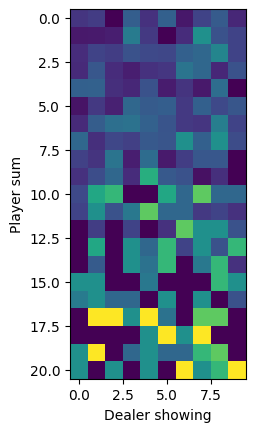

In [31]:
plt.figure(1)
plt.imshow(state_values)
plt.ylabel("Player sum")
plt.xlabel("Dealer showing")
plt.show()

In [106]:
def epsilon_greedy(q, epsilon=0.05):
    s = env.get_state()
    s_idx1 = s["player_sum"]-1
    s_idx2 = s["dealer_showing"]-1
    if q[s_idx1, s_idx2, 0] > q[s_idx1, s_idx2, 1]:
        if np.random.uniform() < (1-epsilon):
            return "hit" 
        else:
            return "stick"
    else:
        if np.random.uniform() < (1-epsilon):
            return "stick"  
        else:
            return "hit"


state_action_values = np.zeros((21, 10, 2))
counts = np.zeros_like(state_action_values)
env = Environment()

# Monte Carlo Control
for _ in range(1000000):
    episode = {
        "states":[env.reset()],
        "rewards":[0],
        "actions":[],
    }
    
    terminated = False
    
    while not terminated:
        action = epsilon_greedy(state_action_values)
        state, reward, terminated = env.step(action)
        if not terminated:
            episode["states"].append(state.copy())
        episode["rewards"].append(reward)
        episode["actions"].append(action)

    for t, (s, a) in enumerate(zip(episode["states"], episode["actions"])):
        s_idx1 = s["player_sum"]-1
        s_idx2 = s["dealer_showing"]-1
        a_idx = 0 if a == "hit" else 1
        
        counts[s_idx1, s_idx2, a_idx] += 1
        g = sum(episode["rewards"][t:])
        state_action_values[s_idx1, s_idx2, a_idx] += (1/counts[s_idx1, s_idx2, a_idx]) \
                                                          * (g-state_action_values[s_idx1, s_idx2, a_idx])

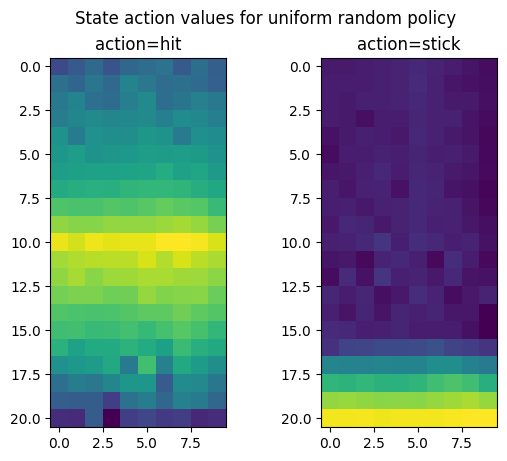

In [107]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(state_action_values[:, :, 0])
axs[0].set_title("action=hit")
axs[1].imshow(state_action_values[:, :, 1])
axs[1].set_title("action=stick")
fig.suptitle("State action values for uniform random policy")
plt.show()